In [2]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from scipy.sparse import hstack,vstack
from sklearn.linear_model import LogisticRegression
import taskALoader as t_a
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC,SVC
from sklearn.utils import class_weight
from sklearn.metrics import classification_report,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV,ShuffleSplit
from sklearn.model_selection import PredefinedSplit
#class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
from langdetect import detect 

In [3]:
df = pd.read_csv("task_A_dataset.csv").fillna(' ')
data = t_a.json_creator(df)
X,y = t_a.get_data(data,post_title_weight=True)



X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train_all, y_train_all, test_size=0.25, random_state=1)

['a' 'b' 'c' 'd']


{0: 31, 1: 8, 2: 21, 3: 40}
31.0
8.0
21.0
40.0


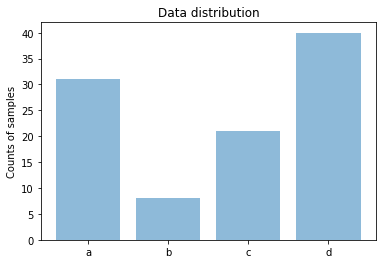

In [4]:
t_a.display_class_dis(y_test)

In [6]:
def get_predefined_split(features_train, features_val, target_train, target_val):
    always_train = np.empty((target_train.shape[0]), dtype=np.int32)
    #print(target_train.shape[0])
    always_train[:] = -1
    always_validate = np.empty((target_val.shape[0]), dtype=np.int32)
    always_validate[:] = 0
    pred_split_indices = np.concatenate((always_train, always_validate))
    curr_target_train = np.concatenate((target_train, target_val))
    #curr_features_train = vstack((features_train, features_val))
    curr_features_train = np.concatenate((features_train, features_val))
   
    ps = PredefinedSplit(test_fold=pred_split_indices)

    return curr_features_train, curr_target_train, ps




In [7]:

X,y,ps = get_predefined_split (X_train,X_val,y_train,y_val)


PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0]))


In [8]:
corpus_df = pd.read_csv("clpsych19_training_data/shared_task_posts.csv").fillna(' ')
p_title = corpus_df['post_title']
p_body = corpus_df['post_body']
corpus_text = pd.concat([p_title,p_body]) 

'\nty = TfidfVectorizer()\nty.fit(corpus_text)\n'

NameError: name 'ty' is not defined

In [11]:
 
class TfidfVectorizerWrapper(TfidfVectorizer):
    
    def fit(self,x,y=None, **fit_params):
        x = corpus_text
        return super(TfidfVectorizerWrapper, self).fit(x, y, **fit_params)
        
    def transform(self, x, y=None, **fit_params):
        #x = [content.split('\t')[0] for content in x]  # filtering the input
        return super(TfidfVectorizerWrapper, self).transform(x, y, **fit_params)       
        


In [12]:
def svc_param_selection(X_train,X_val,y_train,y_val):
    

    
    linear_pipeline = Pipeline(
        [
            ('tfidf',
             TfidfVectorizerWrapper(decode_error='ignore', use_idf=True, ngram_range=(1, 2), lowercase=True,
                             stop_words='english',
                             analyzer='word', max_features=40000)),
            ('classifier', LinearSVC(class_weight='balanced',max_iter=2000))]
    )

    
    
    ngram_range=[(1, 2), (1, 3), (1, 4), (1, 5)]
    max_features=[100000, 200000, 300000, 400000, 500000]
    #max_features = [500000]
    min_df=[1, 2, 3]
    
    
    
    X,y,ps = get_predefined_split (X_train,X_val,y_train,y_val)
    
    Cs = [0.001, 0.01, 0.1, 1, 10]
    Ls = ['l1','l2']
    multi_class = ['ovr','crammer_singer']
    #gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {"tfidf__ngram_range": ngram_range,
                  "tfidf__use_idf": [True],
                  "tfidf__max_features": max_features,
                  "tfidf__min_df": min_df,
                  "tfidf__sublinear_tf": [True],
                  "classifier__C": Cs,
                  "classifier__multi_class":multi_class
                             
                 }
    
   
    
    grid_search = GridSearchCV(linear_pipeline, param_grid,cv=ps,scoring='f1_macro', refit=False)
    
    clf=grid_search.fit(X, y)
 
    
    grid_search.best_params_
    return grid_search.best_params_,clf

In [ ]:
best_pars,model = svc_param_selection(X_train,X_val,y_train,y_val)

/home/semere/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
def runBestSVM(train,train_labels,test,test_labels,best_pars):
    
    
    c = best_pars['classifier__C']
    multi_class = best_pars['classifier__multi_class']
    max_features = best_pars['tfidf__max_features']
    min_df = best_pars['tfidf__min_df']
    ngram_range=best_pars['tfidf__ngram_range']
    sublinear_tf = best_pars['tfidf__sublinear_tf']
    use_idf = best_pars['tfidf__use_idf']
    
    linear_pipeline = Pipeline(
        [
            ('tfidf',
             TfidfVectorizerWrapper(decode_error='ignore', 
                                    ngram_range=ngram_range, lowercase=True,stop_words='english',
                             analyzer='word', max_features=max_features,min_df=min_df,
                                    sublinear_tf=sublinear_tf,use_idf=use_idf)),
            
            ('classifier', LinearSVC(C=c,multi_class=multi_class,class_weight='balanced',max_iter=2000))]
    )
    
    
    
    
   
    linear_pipeline.fit(train,train_labels)
    predicted=linear_pipeline.predict(test)
    print(classification_report(test_labels, predicted))
    print ("Accuracy: {}".format(accuracy_score(test_labels, predicted)))
    return linear_pipeline

In [38]:
model = runBestSVM(X_train,y_train,X_val,y_val,best_pars)   #Evaluation on dev set
runBestSVM(X_train,y_train,X_test,y_test,best_pars)         #Evaluation on test set

              precision    recall  f1-score   support

           0       0.89      0.59      0.71        29
           1       0.20      0.09      0.13        11
           2       0.20      0.12      0.15        17
           3       0.57      0.88      0.69        42

   micro avg       0.58      0.58      0.58        99
   macro avg       0.47      0.42      0.42        99
weighted avg       0.56      0.58      0.54        99

Accuracy: 0.5757575757575758
              precision    recall  f1-score   support

           0       0.78      0.68      0.72        31
           1       0.17      0.12      0.14         8
           2       0.50      0.05      0.09        21
           3       0.54      0.88      0.67        40

   micro avg       0.58      0.58      0.58       100
   macro avg       0.50      0.43      0.41       100
weighted avg       0.57      0.58      0.52       100

Accuracy: 0.58


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizerWrapper(analyzer='word', binary=False, decode_error='ignore',
            dtype=<class 'numpy.float64'>, encoding='utf-8',
            input='content', lowercase=True, max_df=1.0,
            max_features=500000, min_df=1, ngram_range=(1, 2), norm='l2',
            pr...0,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0))])